# Predicting Loan Status Based on Applicant Income and Loan Amount

## Introduction

### Background Information

Applying for a loan can be a tiring, extensive process. Many variables can affect one's loan approval status, and it is hard to determine which one is more significant for a successful application. 

Knowing what to look for in a when applying for a loan application is essential, given that rejection for a loan can affect credit score thus making it even more difficult to successfully acquire loans in the future. 

To aid in facilitating this common problem, this project aims to answer the following question: 

>*"Is it possible to determine loan approval status based on household income (co-applicant and applicant income), loan term, and loan amount?."*

### Dataset Description

To answer the proposed question, the dataset `loan_data.csv` will be used. Our dataset contains information on several loan applicants and was sourced from Kaggle. The dataset contains 13 columns and 381 rows, each of which represent a unique observation (i.e a loan application). Each column in the dataset represents the following:


| Variable             | Description                                                                   |
|----------------------|-------------------------------------------------------------------------------|
| `Loan_ID`            | A unique loan ID                                                              |
| `Gender`             | applicant gender, being male or female.                                       |
| `Married`            | applican marital status, being married(yes) or not married(No).               |
| `Dependents`         | Number of persons depending on the applicant.                                 |
| `Education`          | Applicant Education, being graduate or undergraduate.                         |
| `Self_Employed`      | If applicant is self-employed, options being yes or no.                       |
| `ApplicantIncome`    | Applicant income in dollars.                                                  |
| `CoapplicantIncome`  | Co-applicant income in dollars.                                               |
| `LoanAmount`         | Loan amount in thousands of dollars.                                          |
| `Loan_Amount_Term`   | Terms of the loan in months.                                                  |
| `Credit_History`     | if applicant's credit history meets guidelines.                               |
| `Property_Area`      | If applicants are living in urban, semi-Urban or rural setting.               |
| `Loan_Status`        | Loan approved, options being yes or no.                                       |

*<p><center> Figure 1.0: Variables and Description </center></p>*

## Methods and results

**Source:** https://www.kaggle.com/datasets/bhavikjikadara/loan-status-prediction

In [1]:
## Required packages and versions
install.packages("gridExtra")
library(gridExtra)
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows
set.seed(2024)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip   

ERROR: Error in library(themis): there is no package called ‘themis’


### Preliminary Exploratory Data Analysis

#### 1. Load the Original Dataset

In [2]:
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


##### **Table 0: Original Dataset**

In [3]:
loan_data

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y
LP001024,Male,Yes,2,Graduate,No,3200,700,70,360,1,Urban,Y
LP001027,Male,Yes,2,Graduate,NA,2500,1840,109,360,1,Urban,Y
LP001029,Male,No,0,Graduate,No,1853,2840,114,360,1,Rural,N
LP001030,Male,Yes,2,Graduate,No,1299,1086,17,120,1,Urban,Y


*<p><center> Figure 1.1: Original Dataset </center></p>*

##### **Table 1: Untidy `loan_data`**

As shown in Figure 1.1, the dataset is very large. There are too many rows for us to examine. We can pinpoint exactly how many rows there are using the function `nrow()`

In [4]:
nrow(loan_data)

[1] 381

Because of the large volume of observations, the `head()` function will be used to get an overview of the dataset. The first 6 rows of the original dataset `loan_data` are shown below in Figure 1.2.

In [5]:
head(loan_data)

Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
LP001003,Male,Yes,1,Graduate,No,4583,1508,128,360,1,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0,66,360,1,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120,360,1,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0,141,360,1,Urban,Y
LP001013,Male,Yes,0,Not Graduate,No,2333,1516,95,360,1,Urban,Y
LP001024,Male,Yes,2,Graduate,No,3200,700,70,360,1,Urban,Y


*<p><center> Figure 1.2: Sliced Loan Data </center></p>*

From the original dataset table above, a few problems can be noticed, which will be addressed in the data cleaning process:

1. The column `Loan_Status` is not stored as a categorical variable.
2. There is no variable for the total income amount of the applicant's household.
3. There are rows with missing values.
4. Some of the column names are not standardized. Some spaces are separated with underscores, such as `Self_Employed`, some with capital letters, such as `LoanAmount`.

### 2. Data wrangling and cleaning

To tidy up our data, the following steps were followed:

1. Used the `mutate` and `as_factor` functions to change column `Loan_Status` to a categorical variable.
2. Use the `mutate` function to create a new column named `TotalIncome` using the `ApplicantIncome` and `CoapplicantIncome` columns. Thus, creating a new colum for the total household income (i.e applicant and co-applicant income).
3. Use the `drop_na()` function to drop rows containing missing values.
4. Standardize the column names by assigning the new column names to a vector and passing it to the `colnames` function.

In [10]:
# clean the dataset accordingly
loan_data <- read_csv("https://raw.githubusercontent.com/maricardosoo/DSCI-100-group-project/main/data/loan_data.csv")

loan_data <- loan_data |> 
    mutate(Loan_Status = as_factor(Loan_Status)) |>
    mutate(TotalIncome = ApplicantIncome + CoapplicantIncome) |>
    drop_na() |>
    select(-Loan_ID, -Gender, -Married, -Property_Area)

# Standardising column names
colnames(loan_data) <- c("Dependents", "Education", "SelfEmployed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "LoanTerm", "CreditHistory", "LoanStatus", "TotalIncome")

loan_data

Rows: 381 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): Loan_ID, Gender, Married, Dependents, Education, Self_Employed, Pro...
dbl (5): ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, C...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,Yes,3000,0,66,360,1,Y,3000
0,Not Graduate,No,2583,2358,120,360,1,Y,4941
0,Graduate,No,6000,0,141,360,1,Y,6000
0,Not Graduate,No,2333,1516,95,360,1,Y,3849
2,Graduate,No,3200,700,70,360,1,Y,3900
0,Graduate,No,1853,2840,114,360,1,N,4693
2,Graduate,No,1299,1086,17,120,1,Y,2385
0,Graduate,No,4950,0,125,360,1,Y,4950


*<p><center> Figure 2.0: Tidied Loan Data </center></p>*

# !!! Finish this

As seen in the table above, there is significantly (~48%) more positive classes (LoanStatus == Y) than negative classes. This class imbalance could lead to worse performance in our classifier. Hence, there is a need to balance these classes by 

Similar to Figure 1.1, there are far too many observations to properly examine the data. The `head()` function will again be used to see the tidied data more clearly.

In [11]:
head(loan_data)

Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,Yes,3000,0,66,360,1,Y,3000
0,Not Graduate,No,2583,2358,120,360,1,Y,4941
0,Graduate,No,6000,0,141,360,1,Y,6000
0,Not Graduate,No,2333,1516,95,360,1,Y,3849
2,Graduate,No,3200,700,70,360,1,Y,3900


*<p><center> Figure 2.1: Sliced and Tidied Loan Data </center></p>*

### 3. Initial Split and Training Data Summary Tables for `loan_data`

We must first split the data `loan_split` using the function `initial_split`.

>Since the goal is to predict loan status, the strata is set to the variable `LoanStatus`. And the proportion of the dataset allocated to training data is 0.75.

Then, we divide it into training data, `loan_train`, and testing data, `loan_test` using the functions `training()` and `testing()`.

In [12]:
loan_split <- initial_split(loan_data, prop = 0.75, strata = LoanStatus)
loan_train <- training(loan_split)
loan_test <- testing(loan_split)

##### **Table 3: Training Dataset**

Using the `head()` function, the first 6 rows of the training data can be examined.

In [8]:
head(loan_train)

Dependents,Education,SelfEmployed,ApplicantIncome,CoapplicantIncome,LoanAmount,LoanTerm,CreditHistory,LoanStatus,TotalIncome
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Graduate,No,4583,1508,128,360,1,N,6091
0,Graduate,No,3510,0,76,360,0,N,3510
0,Not Graduate,No,4887,0,133,360,1,N,4887
0,Not Graduate,No,7660,0,104,360,0,N,7660
0,Not Graduate,No,2600,1911,116,360,0,N,4511
0,Not Graduate,No,1442,0,35,360,1,N,1442


*<p><center> Figure 3.0: Training Data for Loan Status </center></p>*

2. *TODO* provide a description of summary data

In [13]:
loan_train_summary <- loan_train |>
    group_by(LoanStatus) |>
    summarize(Count = n(), MeanApplicantIncome = mean(ApplicantIncome), MeanCoapplicantIncome = mean(CoapplicantIncome), MeanLoanAmount = mean(LoanAmount), MeanLoanTerm = mean(LoanTerm))

##### **Table 4: Training Dataset Summary**

In [10]:
loan_train_summary

LoanStatus,Count,MeanApplicantIncome,MeanCoapplicantIncome,MeanLoanAmount,MeanLoanTerm
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
N,66,3417.439,1437.970,100.1667,345.0909
Y,164,3638.348,1215.457,104.1646,340.7561


*<p><center> Figure 3.1: Summary of Loan Data </center></p>*

*TODO* provide implications of training dataset summary

### 4. Preliminary visualization of data

#### 4.1. Distribution of key predictors

**Predictor Distributions:** It is necessary to visualize the distribution of the predictors (`ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, and `LoanTerm`) to gather more information on the data set and better understand the implications of their usage in the knn algorithm. To do so, it is necessary to create 5 histograms: `income_dist_plot`, `coincome_dist_plot`, `loan_amount_plot`, `loan_term_plot`, and `loan_combined_plot`.

*TODO* add figure labels for each plot

In [38]:
options(repr.plot.width=13, repr.plot.height=13)

income_dist_plot <- loan_train |>
    ggplot(aes(x=ApplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of applicant incomes", x = "Applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 15))


coincome_dist_plot <- loan_train |>
    ggplot(aes(x=CoapplicantIncome, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of co-applicant incomes", x = "Co-applicant Income ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 15))


loan_amount_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan amount (per month)", x = "Total Loan Amount in thousands ($)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 15))


loan_term_plot <- loan_train |>
    ggplot(aes(x=LoanTerm, fill=LoanStatus)) +
    geom_histogram(bins=50) +
    labs(title = "Distribution of loan term (months)", x = "Total Loan term (months)", y = "Frequency", fill="Loan approved?") +
    theme(text = element_text(size = 15))

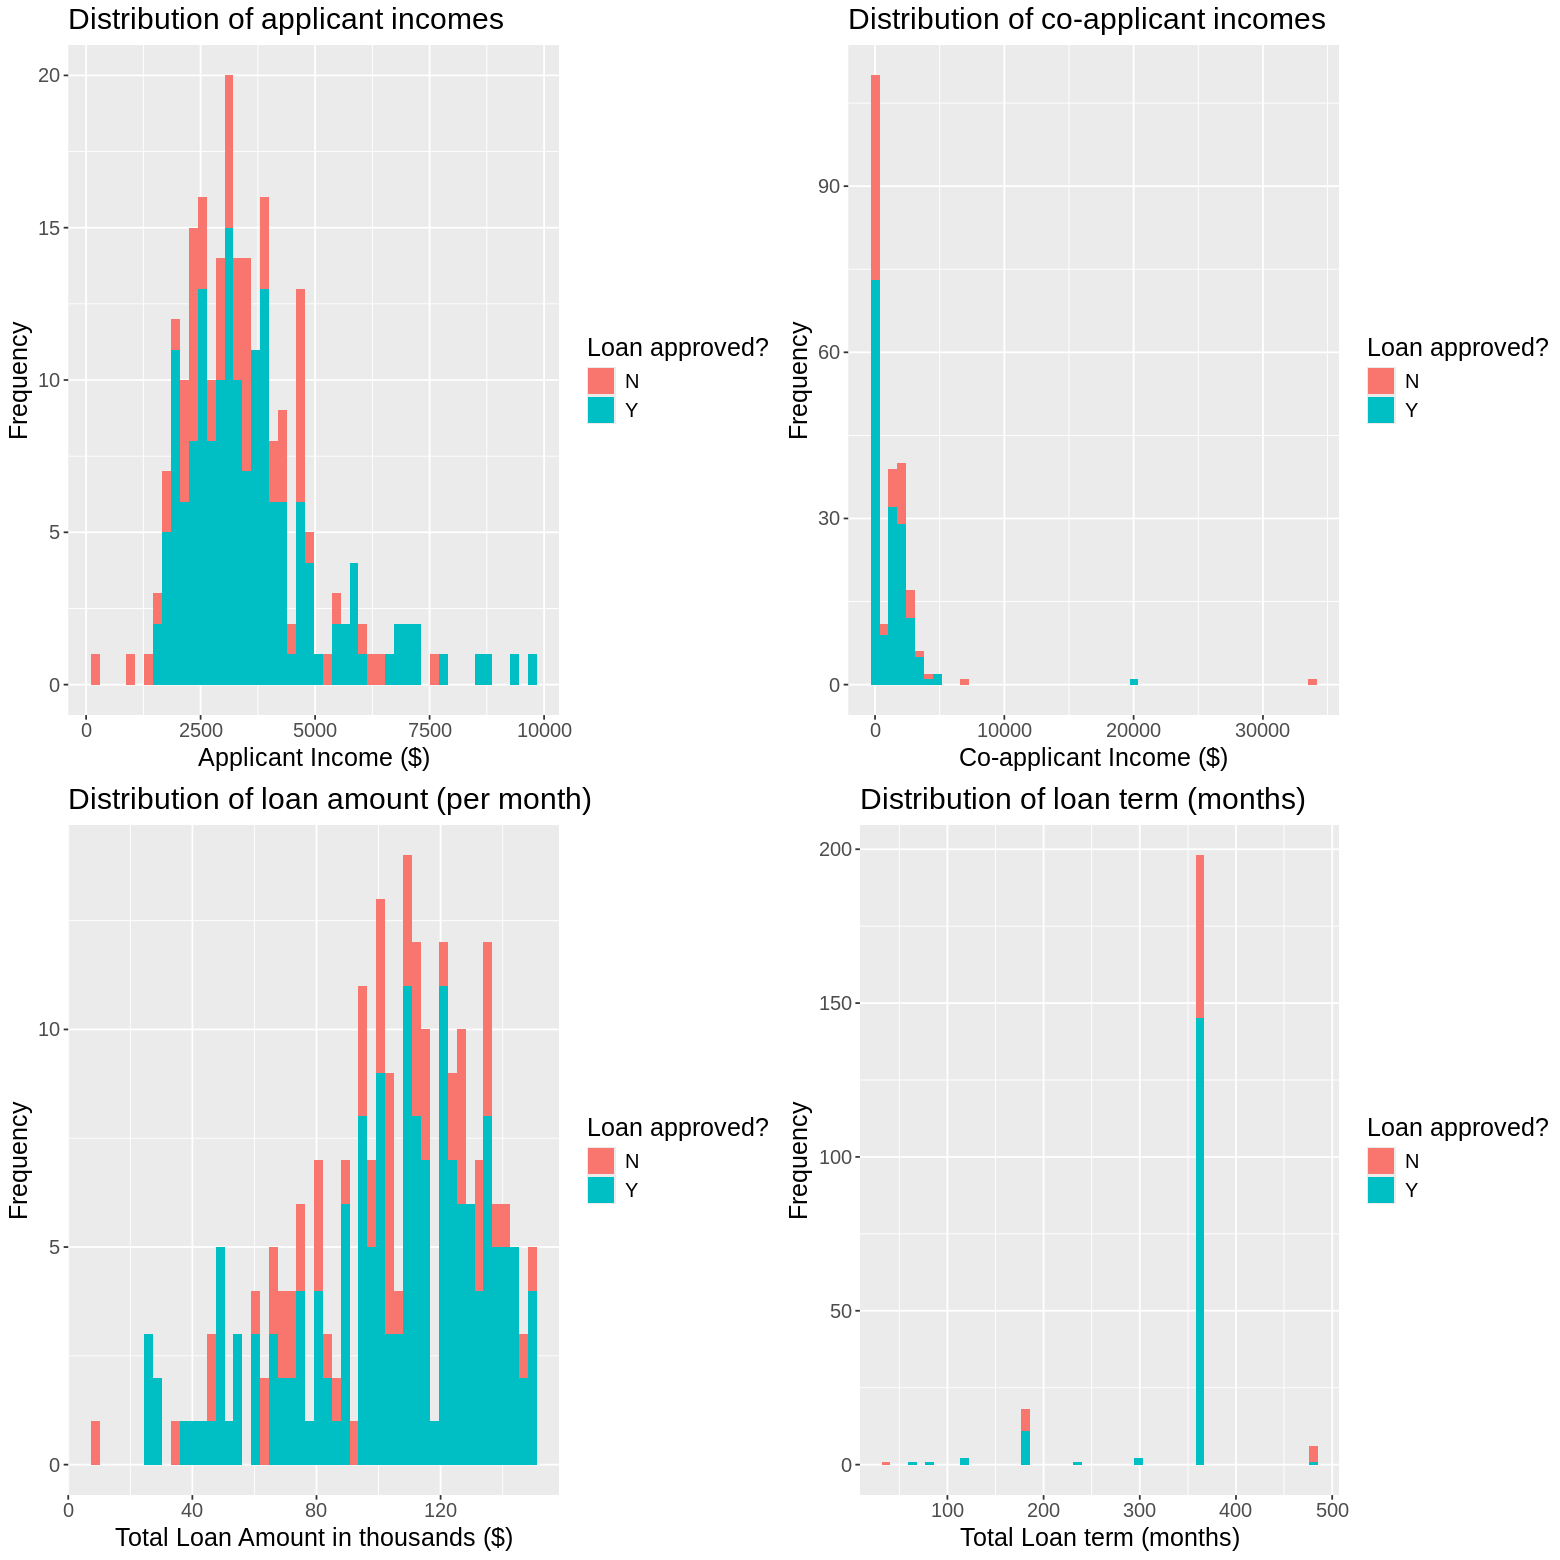

In [39]:
grid.arrange(income_dist_plot, coincome_dist_plot, loan_amount_plot, loan_term_plot, ncol = 2, nrow = 2)

#### 4.2. Relationship between Income and Loan Amount

**Relationship Analysis:** To prepare for the KNN classification, it is necessary to explore the relationship between predictor variables and the response variable. The scatter plot `relationship_plot` should better demonstrate the relationship between `TotalIncome`, `TotalLoanAmount` and `LoanStatus`.

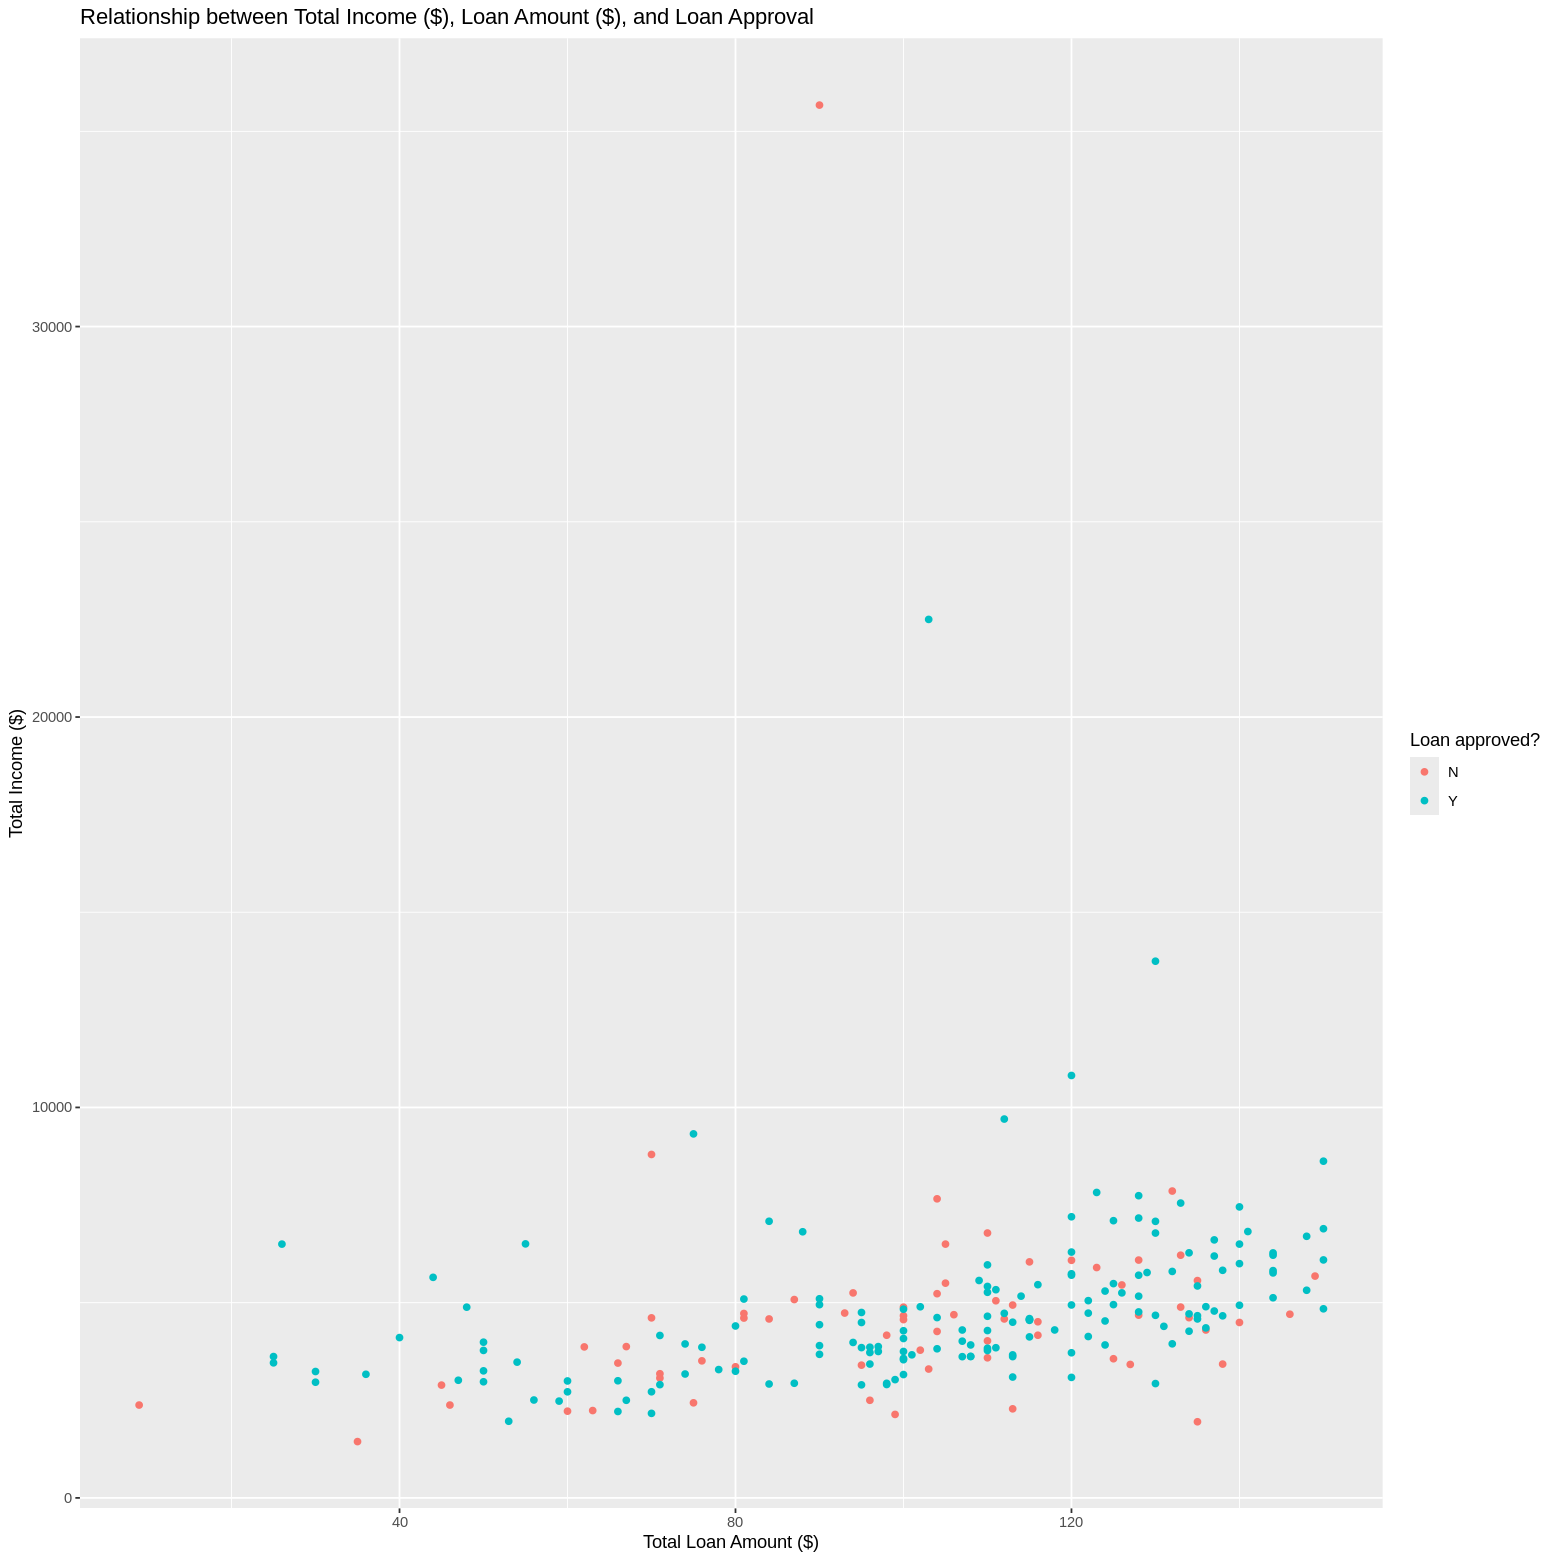

In [13]:
relationship_plot <- loan_train |>
    ggplot(aes(x=LoanAmount, y=TotalIncome, color=LoanStatus)) +
    geom_point() + 
    labs(title = "Relationship between Total Income ($), Loan Amount ($), and Loan Approval", x="Total Loan Amount ($)", y="Total Income ($)", color="Loan approved?")

In [ ]:
relationship_plot

#### 5. Predictors Selection and Data Analysis from Visualization

 This project aims to use the following variables as predictors:
 - `ApplicantIncome`: Monthly income in dollars for the main applicant
 - `CoapplicantIncome`: Monthly income in dollars for any co-applicants in the main applicant's household
 - `LoanAmount`: Loan amount in thousands of dollars
 - `LoanTerm`: Loan term in months

 *TODO* explain why we chose these predictors

In the preliminary data analysis, the data summary includes the number of occurrences for each class, and the mean values of the predictors intended to be used.

**1.** There are almost twice as many positive `LoanStatus` class occurrences as negative ones. This will lead to a class imbalance that affects the classifier's performance. To solve this, either an upsample of the negative classes or a downsample of the positive classes will be necessary.

**2.** The predictors intended to be used have largely the same mean values for both the positive and negative classes. This could be due to large variance or outliers within the predictors affecting the mean.

The visualizations created involve the distributions of the predictors intended to be used. From the visualizations, it is possible to see that there are some class imbalances for outlier values, especially in `Applicant/co-applicantIncome` and the `LoanTerm`. This could lead to poor classification for new observations near the outlier values and may need to be removed.

Other visualizations involving scatter plots of the relationships between predictors will be necessary. This will allow for determining if there is any clear grouping occurring, and to potentially determine which predictors are the most important in the classifier.

## Creating the model

To create our model, the following steps will be taken:

1. Create a recipe that predicts ```LoanStatus```, with ```ApplicantIncome, CoapplicantIncome, LoanAmount, LoanTerm``` as predictors.
2. Create a specification that uses k-nearest neighbors, with neighbors = tune() to select the best ```K``` value.
3. Split the data into 10 folds to perform cross-validation.
4. Create a workflow to train the classifier with ```tune_grid()```.

### 1. Dealing with class imbalance

As seen in the summary table presented previously, the positive class (LoanStatus == Y) appears significantly (~48%) more than the negative class. This imbalance could lead to poor performance of the classifier. When building the model,the negative class will be upsampled by using ```step_upsample()``` as part of the recipe. It is important to set ```skip = TRUE``` to ensure that the upsampling is done only on the training data.

The predictors were also centered and scaled to ensure they have equal impact on the classifier.

In [14]:
loan_recipe <- recipe(LoanStatus ~ ApplicantIncome + CoapplicantIncome + LoanAmount +  LoanTerm + CreditHistory, data = loan_train) |>
    step_upsample(LoanStatus, skip = TRUE) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

### 2. Training the model

In [15]:
# K-nearest neighbour model specification
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# Perform 10 fold-cross valdiation
loan_vfold <- vfold_cv(loan_train, v = 10, strata = LoanStatus)

# K value in range [0, 50]
gridvals <- tibble(neighbors = c(1:50))

# Create workflow
knn_results <- workflow() |>
      add_recipe(loan_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = loan_vfold, grid = gridvals) |>
# Collect metrics, filter for accuracy
      collect_metrics() |>
      filter(.metric == "accuracy") |>
      select(neighbors, mean) |>
      arrange(desc(mean))

head(knn_results)

neighbors,mean
<int>,<dbl>
49,0.8440053
50,0.8440053
3,0.8356719
4,0.8356719
47,0.8352931
48,0.8352931


### 3. Choosing a ```K``` value

- *TODO* do some more description of our chosen K value and choice of visualization to do so.
- *TODO* provide labels for visualization

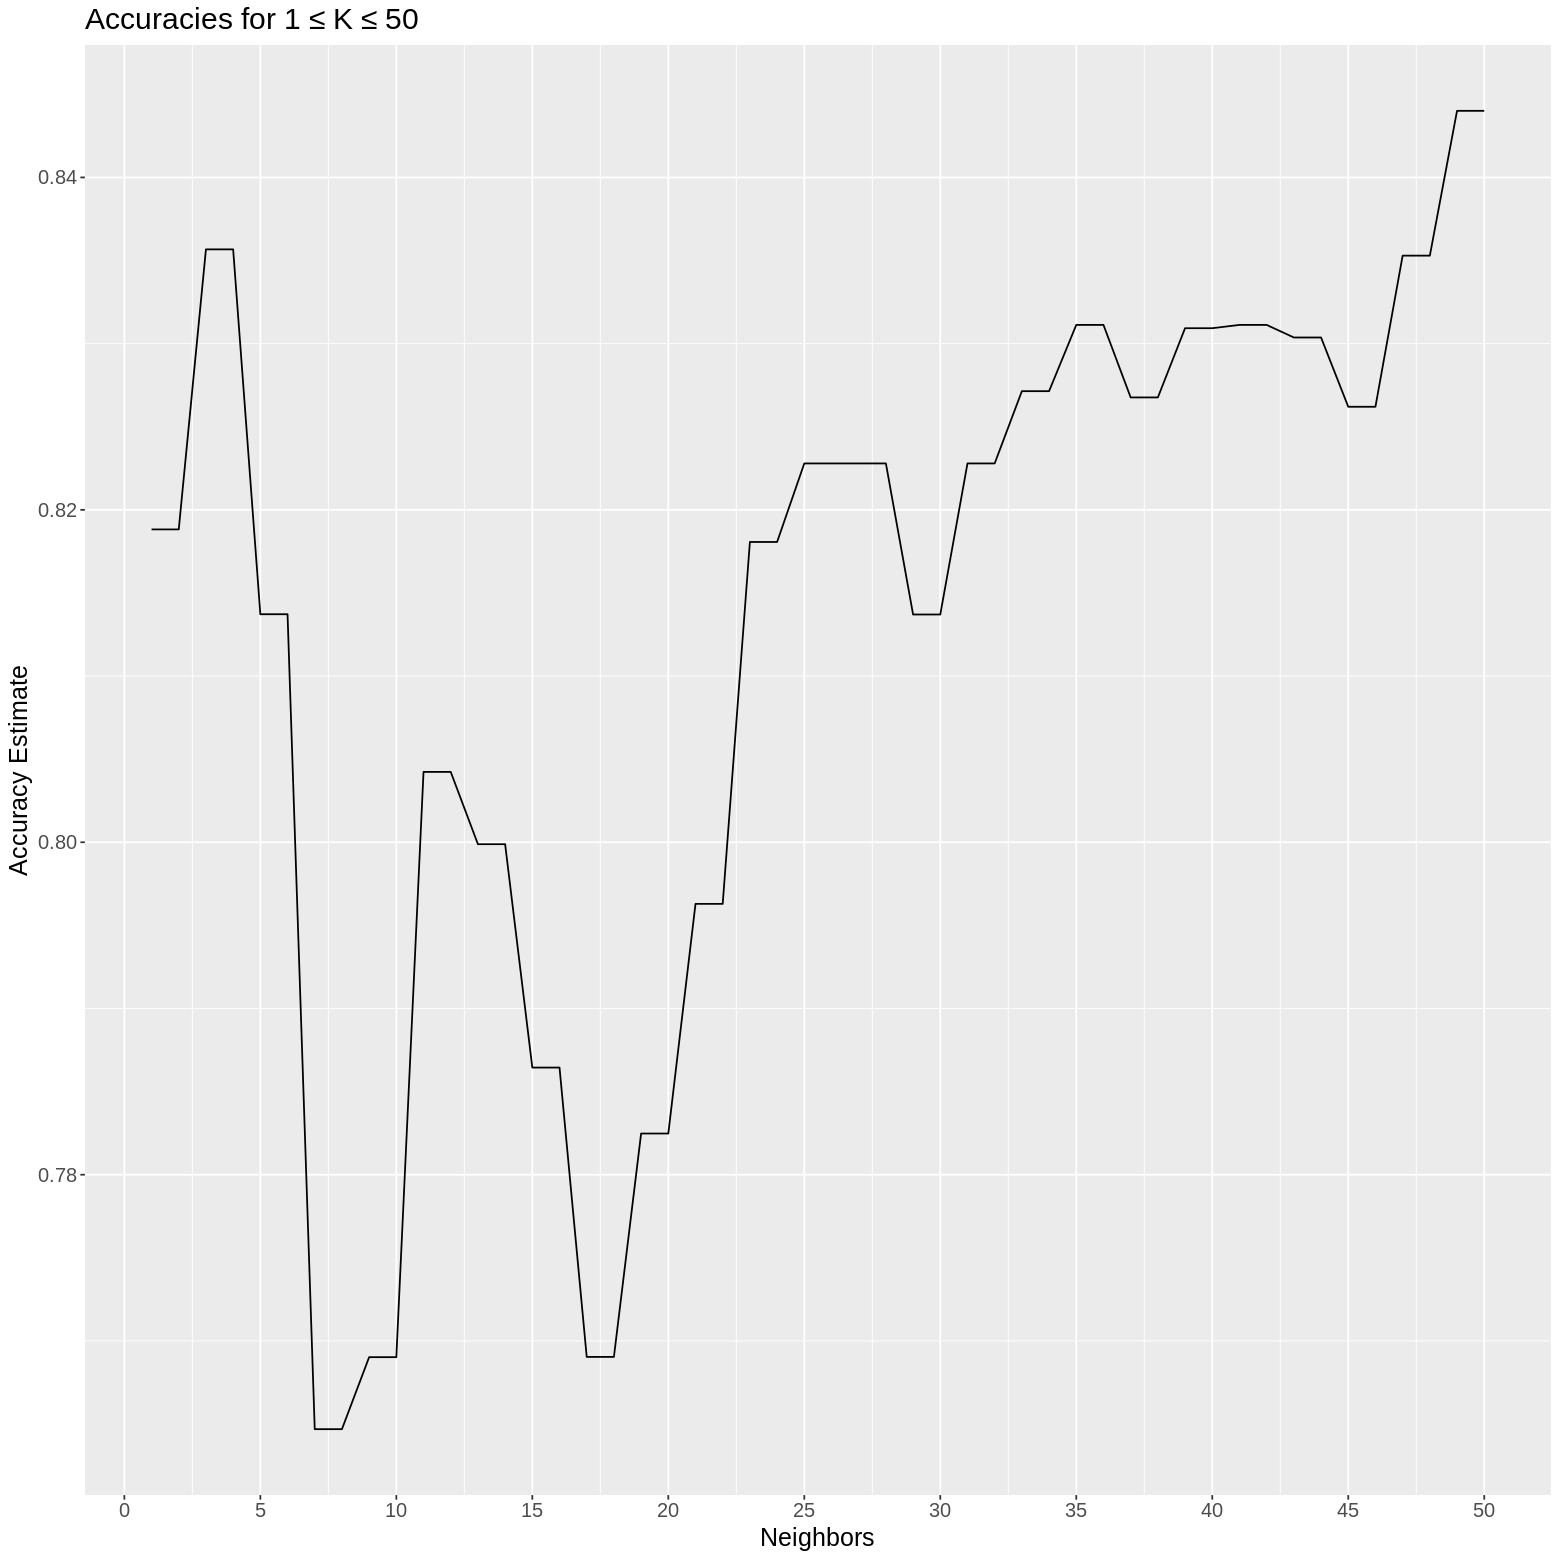

In [16]:
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracies for 1 ≤ K ≤ 50") +
      scale_x_continuous(breaks = seq(0, 50, by = 5)) + # adjusting the x-axis
      theme(text = element_text(size = 15))

accuracy_versus_k

### 4. Building the final model

*TODO* provide description for final model creation

In [17]:
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 29) |>
    set_engine("kknn") |>
    set_mode("classification")

loan_fit <- workflow() |>
    add_recipe(loan_recipe) |>
    add_model(final_spec) |>
    fit(data = loan_train)

### 5. Testing the final model

*TODO* provide description for accuracy of the final model

In [18]:
predictions <- predict(loan_fit, loan_test) %>%
               bind_cols(loan_test)

metrics <- predictions |>
    metrics(truth = LoanStatus, estimate = .pred_class) |>
    filter(.metric == "accuracy") 

metrics

#confusion matrix, identifies the areas the model is weak at classifying
conf_mat <- predictions |>
    conf_mat(truth = LoanStatus, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8076923


          Truth
Prediction  N  Y
         N 12  4
         Y 11 51

*TODO* provide more visualization to further demonstrate accuracy of the model

## Discussion

### Discussion of Results

*TODO*

### Summary

*TODO*

### Impact and significance

*TODO*

### Future Questions

*TODO*

## References

*TODO*